In [1]:
from ImpLogReg import ImpLogReg
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
from sklearn.linear_model import LogisticRegression
import itertools as it
from tqdm import tqdm
import pba
import random

import matplotlib
font = {'size'   : 14,'family' : 'Times New Roman'}
matplotlib.rc('font', **font)

from LRF import *


In [2]:
def generate_results(data):
    # set seed for reproducability
    np.random.seed(10)
    results = pd.Series(index = data.index, dtype = 'bool')
    
    for i in data.index:

        results.loc[i] = data.loc[i,0] >= 5+2*np.random.randn()    
        
    return results


### Generate Data

In [3]:
s = 1234
np.random.seed(s)

# Params
some = 50 # training datapoints
many = 500 # many test samples

train_data = pd.DataFrame(10*np.random.rand(some,1))
train_results = generate_results(train_data)

test_data = pd.DataFrame(10*np.random.rand(many,1))
test_results = generate_results(test_data)

### Fit logistic regression model on full dataset

In [4]:
base = LogisticRegression()
base.fit(train_data.to_numpy(),train_results.to_numpy())

LogisticRegression()

### Remove uncertain datapoints from the training data

In [5]:
few = 5 #uncertain points
random.seed(12345) # for reproducability
uq_data_index = random.sample([i for i in train_data.index if abs(train_data.loc[i,0]-5) <= 1.5], k = few) # clustered around center

uq_data = train_data.loc[uq_data_index]
uq_results = pd.Series([int(train_results.loc[i]) if i not in uq_data_index else pba.I(0,1) for i in train_results.index], index = train_results.index, dtype='O')
nuq_data = train_data.loc[[i for i in train_data.index if i not in uq_data_index]]
nuq_results = train_results.loc[[i for i in train_data.index if i not in uq_data_index]]

### Fit UQ models

In [6]:
ilr = ImpLogReg(uncertain_class=True, max_iter = 1000)
ilr.fit(train_data,uq_results)


UC Logistic Regression: 100%|██████████| 32/32 [00:00<00:00, 116.53it/s]


### Fit models with missing data


In [7]:
nuq = LogisticRegression()
nuq.fit(nuq_data.to_numpy(),nuq_results.to_numpy())


LogisticRegression()

### Plot results


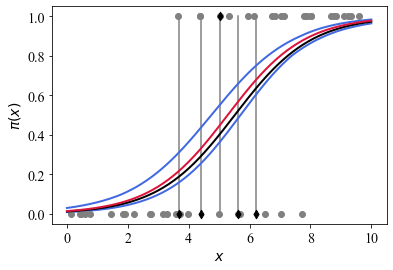

In [9]:
steps = 300
lX = np.linspace(0,10,steps)
lY = base.predict_proba(lX.reshape(-1, 1))[:,1]
lYn = nuq.predict_proba(lX.reshape(-1, 1))[:,1]
lYu = ilr.predict_proba(lX.reshape(-1,1))[:,1]

plt.xlabel('$x$')
plt.ylabel('$\pi(x)$')
plt.scatter(nuq_data,nuq_results,color='grey',zorder=10)
plt.plot(lX,lY,color='k',zorder=10,lw=2,label = 'Truth')
plt.plot(lX,lYn,color='#DC143C',zorder=10,lw=2,label = 'No UQ')

for i in uq_data_index:

    plt.plot([uq_data.loc[i],uq_data.loc[i]],[0,1],color='grey')
    plt.scatter(uq_data.loc[i],train_results.loc[i],marker = 'd',color = 'black',zorder = 14)
    
plt.plot(lX,[i.left for i in lYu],color='#4169E1',lw=2)
plt.plot(lX,[i.right for i in lYu],color='#4169E1',lw=2,label = 'Uncertainty Bounds')

# plt.savefig('../paper/figs/UC.png',dpi = 600)
# plt.savefig('figs/UC.png',dpi = 600)


### Get confusion matrix

In [10]:
# Classify test data
base_predict = base.predict(test_data)

# CLASSIFY NO_UQ MODEL DATA 
nuq_predict = nuq.predict(test_data)

# CLASSIFY UQ MODEL 
ilr_predict = ilr.predict(test_data)

with open('runinfo/UC_cm.out','w') as f:
    print('TRUE MODEL',file = f)
    a,b,c,d = generate_confusion_matrix(test_results,base_predict)
    print('TP=%i\tFP=%i\nFN=%i\tTN=%i' %(a,b,c,d),file = f)

    # Calculate sensitivity and specificity
    print('Sensitivity = %.3f' %(a/(a+c)),file = f)
    print('Specificity = %.3f' %(d/(b+d)),file = f)

    print('DISCARDED DATA MODEL',file = f)
    aa,bb,cc,dd = generate_confusion_matrix(test_results,nuq_predict)
    try:
        ss = 1/(1+cc/aa)
    except:
        ss = None
    try:    
        tt = 1/(1+bb/dd)
    except:
        tt = None
    print('TP=%s\tFP=%s\nFN=%s\tTN=%s' %(aa,bb,cc,dd),file = f)

    # Calculate sensitivity and specificity
    print('Sensitivity = %.3f' %(ss),file = f)
    print('Specificity = %.3f' %(tt),file = f)
    
    print('UQ MODEL',file = f)
    
    aaai,bbbi,ccci,dddi = generate_confusion_matrix(test_results,ilr_predict,throw = False)
    try:
        sssi = aaai/(a+c)
    except:
        sssi = None
    try:    
        ttti = dddi/(b+d)
    except:
        ttti = None

    print('TP=[%i,%i]\tFP=[%i,%i]\nFN=[%i,%i]\tTN=[%i,%i]' %(*aaai,*bbbi,*ccci,*dddi),file = f)

    # Calculate sensitivity and specificity
    print('Sensitivity = [%.3f,%.3f]\nSpecificity = [%.3f,%.3f]' %(*sssi,*ttti),file = f)

    
    aaa,bbb,ccc,ddd,eee,fff = generate_confusion_matrix(test_results,ilr_predict,throw = True)
    try:
        sss = 1/(1+ccc/aaa)
    except:
        sss = None
    try:    
        ttt = 1/(1+bbb/ddd)
    except:
        ttt = None
        
    print('TP=%i\tFP=%i\nFN=%i\tTN=%i\nNP(+)=%i\tNP(-)=%i' %(aaa,bbb,ccc,ddd,eee,fff),file = f)

    # Calculate sensitivity and specificity
    print('Sensitivity = %.3f' %(sss),file = f)
    print('Specificity = %.3f' %(ttt),file = f)
    print('sigma = %.3f' %(eee/(aaa+ccc+eee)),file = f)
    print('tau = %.3f' %(fff/(bbb+ddd+fff)),file = f)
   


### Descriminatory Performance Plots


ROC: 100%|██████████| 1000/1000 [00:05<00:00, 182.48it/s]


FileNotFoundError: [Errno 2] No such file or directory: '../paper/figs/UC_ROC.png'

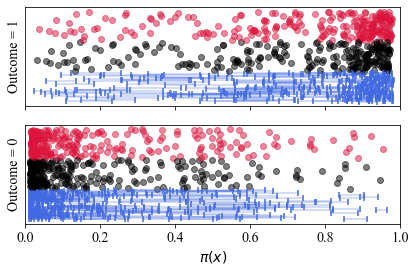

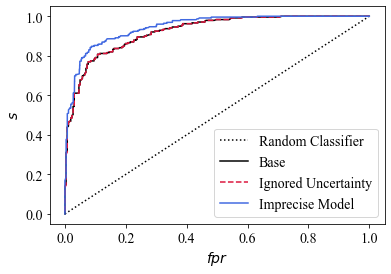

In [11]:
s,fpr,probabilities = ROC(model = base, data = test_data, results = test_results)
nuq_s,nuq_fpr,nuq_probabilities = ROC(model = nuq, data = test_data, results = test_results)
s_t, fpr_t, Sigma, Tau = incert_ROC(ilr, test_data, test_results)
s_i, fpr_i,ilr_probabilities = ROC(ilr, test_data, test_results)

densfig,axdens = plt.subplots(nrows = 2, sharex= True)

for i,(p,u,nuqp,r) in enumerate(zip(probabilities,ilr_probabilities,nuq_probabilities,test_results.to_list())):
    yd = np.random.uniform(-0.1,0.1)
    if r:
        axdens[0].scatter(p,yd,color = 'k',marker = 'o',alpha = 0.5)
        axdens[0].scatter(nuqp,0.21+yd,color = '#DC143C',marker = 'o',alpha = 0.5)
        axdens[0].plot([*u],[yd-0.21,yd-0.21],color = '#4169E1',alpha = 0.3)
        axdens[0].scatter([*u],[yd-0.21,yd-0.21],color = '#4169E1',marker = '|')
    else:
        axdens[1].scatter(p,yd,color = 'k',marker = 'o',alpha = 0.5)
        axdens[1].scatter(nuqp,0.21+yd,color = '#DC143C',marker = 'o',alpha = 0.5)
        axdens[1].plot([*u],[yd-0.21,yd-0.21],color = '#4169E1',alpha = 0.3)
        axdens[1].scatter([*u],[yd-0.21,yd-0.21],color = '#4169E1',marker = '|')
        
        
axdens[0].set(ylabel = 'Outcome = 1',yticks = [])
axdens[1].set(xlabel = '$\pi(x)$',ylabel = 'Outcome = 0',yticks = [],xlim  = (0, 1))

densfig.tight_layout()

rocfig,axroc = plt.subplots(1,1)
axroc.plot([0,1],[0,1],'k:',label = 'Random Classifier')
axroc.set(xlabel = '$fpr$',ylabel='$s$')
axroc.plot(fpr,s,'k',label = 'Base')
axroc.plot(nuq_fpr,nuq_s,color='#DC143C',linestyle='--',label='Ignored Uncertainty')
axroc.plot(fpr_t,s_t,'#4169E1',label='Imprecise Model')
axroc.legend()
rocfig.savefig('figs/UC_ROC.png',dpi = 600)
rocfig.savefig('../paper/figs/UC_ROC.png',dpi = 600)
densfig.savefig('figs/UC_dens.png',dpi =600)
densfig.savefig('../paper/figs/UC_dens.png',dpi =600)


with open('runinfo/UC_auc.out','w') as f:
    print('NO UNCERTAINTY: %.4f' %auc(s,fpr), file = f)
    print('MIDPOINTS: %.4f' %auc(nuq_s,nuq_fpr),file = f)
    print('THROW: %.4f' %auc(s_t,fpr_t), file = f)
    # print('INTERVALS: [%.3f,%.3f]' %(auc_int_min,auc_int_max), file = f)
    


fig = plt.figure()
ax = plt.axes(projection='3d',elev = 45,azim = -45,proj_type = 'ortho')
ax.set_xlabel('$fpr$')
ax.set_ylabel('$s$')
# ax.set_zlabel('$1-\sigma,1-\\tau$')
ax.plot(fpr_t,s_t,'#4169E1',alpha = 0.5)
ax.plot3D(fpr_t,s_t,Sigma,'#FF8C00',label = '$\\sigma$')
ax.plot3D(fpr_t,s_t,Tau,'#008000',label = '$\\tau$')
# ax.plot3D(fpr,s,Nu,'k',label = '$1-\\nu$')

ax.legend()

# plt.savefig('figs/UC_ROC3D.png',dpi = 600)
# plt.savefig('../paper/figs/UC_ROC3D.png',dpi = 600)
plt.clf()

plt.xlabel('$fpr$/$s$')
plt.ylabel('$\\sigma$/$\\tau$')
plt.plot(s_t,Sigma,'#FF8C00',label = '$\\sigma$ v $s$')
plt.plot(fpr_t,Tau,'#008000',label = '$\\tau$ v $fpr$')
plt.legend()


# plt.savefig('figs/UC_ST.png',dpi = 600)
# plt.savefig('../paper/figs/UC_ST.png',dpi = 600)

plt.clf()

### Hosmer-Lemeshow

In [12]:
hl_b, pval_b = hosmer_lemeshow_test(base,train_data,train_results,g = 10)

hl_nuq, pval_nuq = hosmer_lemeshow_test(nuq,train_data,train_results,g = 10)
#
hl_uq, pval_uq = UQ_hosmer_lemeshow_test(ilr,train_data,train_results,g = 10)

with open('runinfo/UC_HL.out','w') as f:
    print('base\nhl = %.3f, p = %.3f' %(hl_b,pval_b),file = f)
    print('no UQ\nhl = %.3f, p = %.3f' %(hl_nuq,pval_nuq),file = f) 

    print('UQ\nhl = [%.3f,%.3f], p = [%.3f,%.3f]' %(*hl_uq,*pval_uq),file = f) 

UQ HL Test: 100%|██████████| 50/50 [00:01<00:00, 44.44it/s]
